<font size="5.8">Summary</font>

An imbalanced classification problem is where there is a highly skewed distribution towards a class. This leads to forcing the predictive models to an unrealistically high classification for majority class (overestimation) resulting very poor performance for minority class (underestimation). Therefore, this is a problem when the minority class is more important than the majority class. To resolve problematic classification of imbalanced classes,
resampling techniques are used to adjust the class distribution of training data (the ratio between the different classes) to feed more balanced data into predictive models; thereby creating a new transformed version of the training set with a different class distribution. Oversampling, Undersampling and combination of them are applied. To measure performance, K-fold cross validation is utilized but cross validation after resampling incorrectly leads to overoptimism and overfitting since the class distribution of the original data is different from the sampled training set. The correct approach is to
resample within K-fold cross validation. These techniques are discussed in details

Python functions and data files to run this notebook are in my [Github](https://github.com/MehdiRezvandehy/Customer_Chrun_Prediction.git) page.

In [1]:
import pandas as pd
import numpy as np
from functions import* # import require functions to run this notebook
import matplotlib.patheffects as pe
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import gridspec
import os
import pickle
import logging
import warnings
warnings.filterwarnings('ignore')

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Data-Processing" data-toc-modified-id="Data-Processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Processing</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Threshold-from-Bootstrapping" data-toc-modified-id="Threshold-from-Bootstrapping-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Threshold from Bootstrapping</a></span></li><li><span><a href="#Resampling" data-toc-modified-id="Resampling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Resampling</a></span><ul class="toc-item"><li><span><a href="#Oversampling" data-toc-modified-id="Oversampling-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Oversampling</a></span></li><li><span><a href="#Undersampling" data-toc-modified-id="Undersampling-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Undersampling</a></span></li><li><span><a href="#Combination-of-Oversampling-and-Undersampling" data-toc-modified-id="Combination-of-Oversampling-and-Undersampling-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Combination of Oversampling and Undersampling</a></span></li></ul></li><li><span><a href="#Test-Set" data-toc-modified-id="Test-Set-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Test Set</a></span></li></ul></div>

# Introduction

It is common that for binary classification we get total accuracy above 90%; however, when we apply a random classifier,  still get close 90% accuracy. That is because of imbalanced class: 90% of one class and 10% of another class. This leads to very low accuracy for rare class that causes a lot of frustration even if we apply a very powerful technique. There are some techniques to resolve this problem. Simple approach is to tweak threshold for assigning a label (class 0 or 1) to each instance. The probability 0.5 is often used as a threshold. For example, if the predicted probability is above 0.5, the instance is labeled as class 1; otherwise, class 0 is assigned. If the threshold manually decreases, the prediction will have more class 1 that leads to higher sensitivity. In order to get more reliable threshold, we run bootstrapping by dividing the data into training set and set. For each run, a model is trained with the training set and applied the trained model on test set to find an threshold that has required metrics (for example sensitivity>0.7). This approach seems very straightforward to get any desired sensitivity; however, it may not be practical to apply tweaking threshold if the predicted sensitivity is very low and decreasing the threshold will artificially increase sensitivity and decrease significantly other metrics.

In this work, resampling approach is applied to resolve problematic classification of imbalanced classes:

**1- Oversampling**

**2- Undersampling**

**3- Combination of Oversampling and Undersampling**

The performance of these techniques are compared with never before seen data set (test set). More details of those techniques will be discussed.

**Customer** churn data set from [Kaggle](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling/version/1) is applied in this notebook. Customer churn is a financial expression referring to losing of a customer or client when a customer abandons interaction with business or company. 


The classifier for this study is **Random Forest (RF)** that is among the most versatile and reliable machine learning algorithms for non-linear and complex data. The RF randomly creates and merges multiple decision trees and predicts a class that gets the most votes among all trees. Despite its simplicity, RF is one of the most powerful ML algorithms available today.

A binary classification will be applied by RF as below:

- The irrelevant features are removed from data. 

- The data set is divided into 80% training set and 20% test set. 

- Data processing is applied for training set including imputation of missing values, normalization and text handling. 

- Train RF algorithm using the training set by implementing a binary classification. 

- The trained model is applied to predict test set. 


# Data Processing 

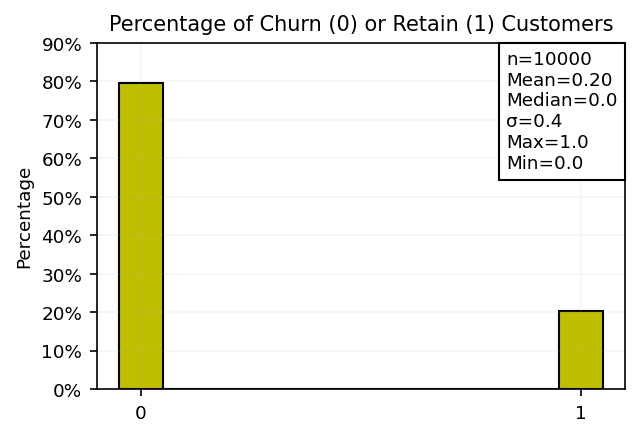

In [2]:
# Read data 'Churn_Modelling.csv'
df = pd.read_csv('./Data/Churn_Modelling.csv')

# Shuffle the data
np.random.seed(42) 
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True) # Reset index

# Remove 'RowNumber','CustomerId','Surname' features
df=df.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=False)

font = {'size'   : 9.5}
plt.rc('font', **font)
fig = plt.subplots(figsize=(10, 3), dpi= 150, facecolor='w', edgecolor='k')
ax1=plt.subplot(1,2,1)
bins = np.array([-0.05,0.05,0.95,1.05])
EDA_plot.histplt (df['Exited'],bins=bins,title='Percentage of Churn (0) or Retain (1) Customers',xlabl="",
         ylabl='Percentage',xlimt=(-0.1,1.1),ylimt=(0,0.9),axt=ax1,x_tick=[0,1],
         scale=1.1,loc=1,font=8,color='y')
plt.show()

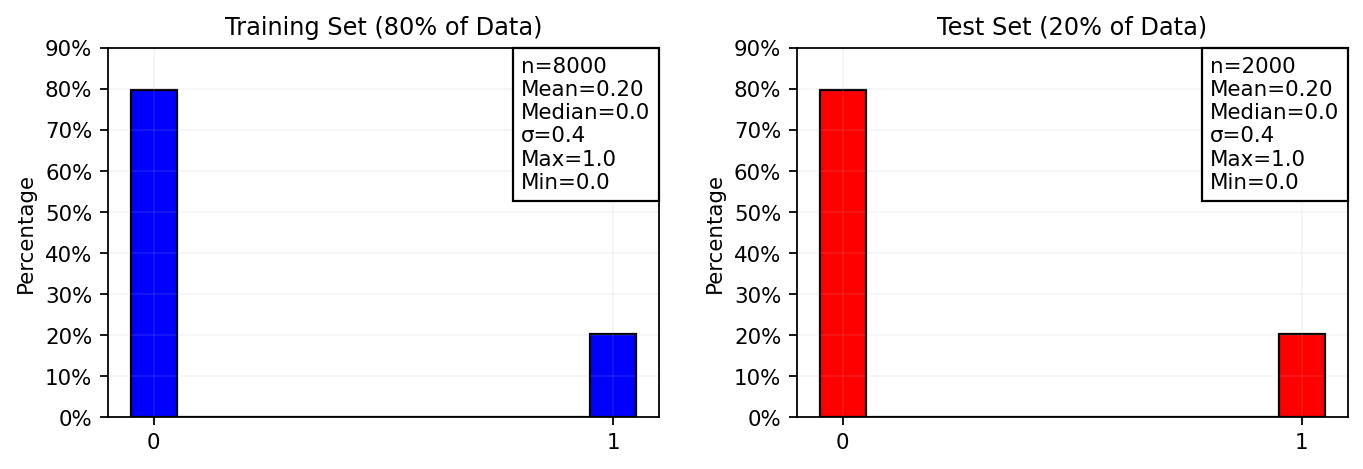

In [3]:
# Training and Test
spt = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in spt.split(df, df['Exited']):
    train_set_strat = df.loc[train_idx]
    test_set_strat  = df.loc[test_idx] 
    
train_set_strat.reset_index(inplace=True, drop=True) # Reset index
test_set_strat.reset_index(inplace=True, drop=True) # Reset index
    
font = {'size'   : 10}
plt.rc('font', **font)

fig = plt.subplots(figsize=(10, 3), dpi= 160, facecolor='w', edgecolor='k')

ax1=plt.subplot(1,2,1)
val=train_set_strat['Exited']
EDA_plot.histplt(val,bins=bins,title="Training Set (80% of Data)",xlabl="",
         ylabl='Percentage',xlimt=(-0.1,1.1),ylimt=(0,0.9),axt=ax1,x_tick=[0,1],
         scale=1.2,loc=1,font=8,color='b')

ax2=plt.subplot(1,2,2) 
val=test_set_strat['Exited']
EDA_plot.histplt(val,bins=bins,title="Test Set (20% of Data)",xlabl="",
         ylabl='Percentage',xlimt=(-0.1,1.1),ylimt=(0,0.9),axt=ax2,x_tick=[0,1],
         scale=1.2,loc=1,font=8,color='r')

plt.subplots_adjust(wspace=0.25)
plt.show()  

In [4]:
################### Data Processing for training set ######################

# Text Handeling
# Convert Geography to one-hot-encoding
Geog_1hot=pd.get_dummies(train_set_strat['Geography'],prefix='Geography')

# Convert gender to 0 and 1
ordinal_encoder = OrdinalEncoder()
train_set_strat['Gender'] = ordinal_encoder.fit_transform(train_set_strat[['Gender']])

# Remove 'Geography'
train_set_strat=train_set_strat.drop(['Geography'],axis=1,inplace=False)
train_set_strat=pd.concat([Geog_1hot,train_set_strat], axis=1) # Concatenate rows

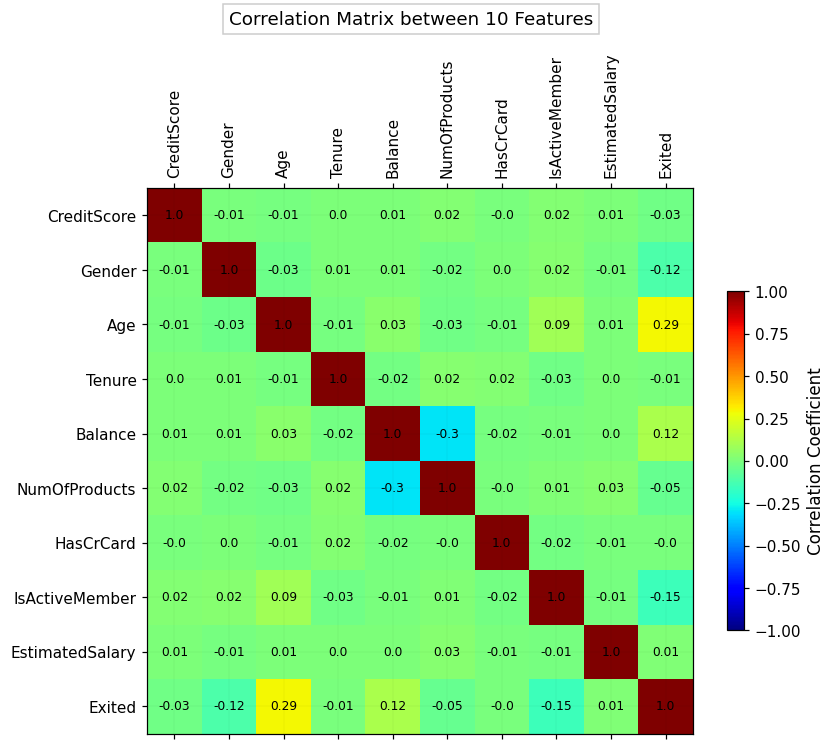

In [5]:
# Correlation matrix
font = {'size'   : 11}
plt.rc('font', **font)
fig, ax=plt.subplots(figsize=(8, 8), dpi= 110, facecolor='w', edgecolor='k')

df_tmp=train_set_strat.drop(['Geography_France','Geography_Germany','Geography_Spain'], axis=1)

corr_array=Correlation_plot.corr_mat(df_tmp,corr_val_font=8,
        title=f'Correlation Matrix between {len(df_tmp.columns)} Features'
         ,titlefontsize=12,xy_title=[1,-3.5],xyfontsize = 10,vlim=[-1, 1],axt=ax)

Figure below show correlation between training features and target feature (Exited). Age has positive correlation and IsActiveMember has negative correlation with target (`Exited`). Other Features are not linearly correlated with the target (`Exited`).

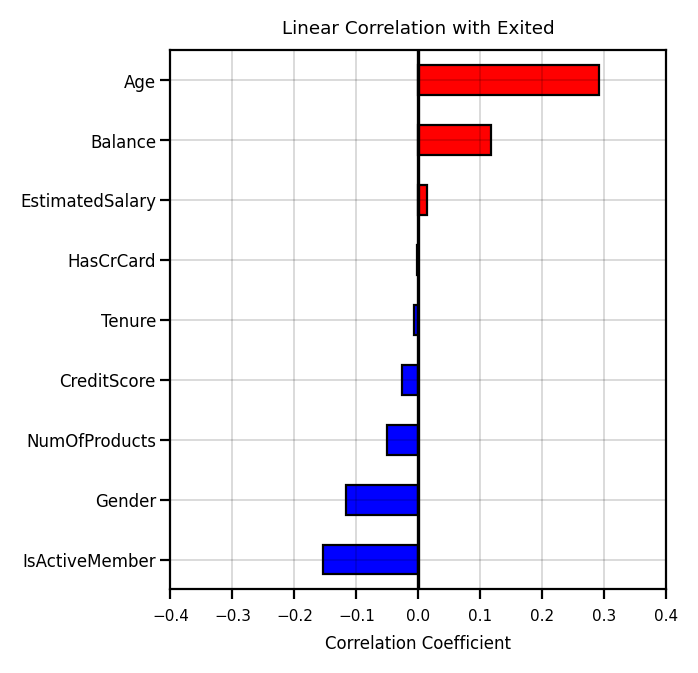

In [6]:
font = {'size'   : 5.5}
plt.rc('font', **font)
ax1 = plt.subplots(figsize=(3.2, 3.5), dpi= 200, facecolor='w', edgecolor='k')

# Plot correlations of attributes with the last column
target='Exited'
corr=df_tmp.corr()
corr=corr[target].drop([target])
coefs=corr.values
clmns=list(corr.index)
Correlation_plot.corr_bar(coefs,clmns=clmns,yfontsize=6.0,xlim=[-0.4,0.4],
                          title=f'Linear Correlation with {target}',ymax_vert_lin=30)

In [7]:
# Standardization 
# Make training features and target
X_train = train_set_strat.drop("Exited", axis=1)
y_train = train_set_strat["Exited"].values

# Divide into two training sets (with and without standization)
clmn=['Geography_France','Geography_Germany','Geography_Spain',
                               'Gender','NumOfProducts','HasCrCard','IsActiveMember']
X_train_for_std = X_train.drop(clmn, axis=1)
X_train_not_std =X_train[clmn]
features_colums=list(X_train_for_std.columns)+list(X_train_not_std.columns)
#
scaler = StandardScaler()
scaler.fit(X_train_for_std)
#
df_train_std=scaler.transform(X_train_for_std)
X_train_std=np.concatenate((df_train_std,X_train_not_std), axis=1)

# Random Forest

In [8]:
# Random Forest for taining set
rnd = RandomForestClassifier(n_estimators=50, max_depth= 25, min_samples_split= 20, bootstrap= True, random_state=42)
rnd.fit(X_train_std,y_train)
y_train_pred=cross_val_predict(rnd,X_train_std,y_train, cv=3)
y_train_proba_rnd=cross_val_predict(rnd,X_train_std,y_train, cv=3, method='predict_proba')

################### Data Processing for test set  ######################
# Convert Geography to one-hot-encoding
Geog_1hot=pd.get_dummies(test_set_strat['Geography'],prefix='Geography')

# Convert gender to 0 and 1
ordinal_encoder = OrdinalEncoder()
test_set_strat['Gender'] = ordinal_encoder.fit_transform(test_set_strat[['Gender']])

# Remove 'Geography'
test_set_strat=test_set_strat.drop(['Geography'],axis=1,inplace=False)
test_set_strat=pd.concat([Geog_1hot,test_set_strat], axis=1) # Concatenate rows

# Standardize data
X_test = test_set_strat.drop("Exited", axis=1)
y_test = test_set_strat["Exited"].values
#
clmn=['Geography_France','Geography_Germany','Geography_Spain',
                               'Gender','NumOfProducts','HasCrCard','IsActiveMember']
X_test_for_std =  X_test.drop(clmn, axis=1)
X_test_not_std =  X_test[clmn]
features_colums=list(X_test_for_std.columns)+list(X_test_not_std.columns)
#
df_test_std=scaler.transform(X_test_for_std)
X_test_std=np.concatenate((df_test_std,X_test_not_std), axis=1)

# Random Forest for test set
y_test_pred=rnd.predict(X_test_std)
y_test_proba_rnd=rnd.predict_proba(X_test_std)

The most common approach for assessment of classification is accuracy, which is calculated by number of true predicted over total number of data. However, accuracy alone may not be practical for performance measurement of classifiers, especially in cease of imbalanced datasets. Accuracy should be considered along with other metrics. Confusion matrix is a much better way to evaluate the performance of a classifier. The general idea is to consider the number of times instances of negative class are misclassified as positive class and vice versa. Three more metrics Sensitivity, Precision and Specificity can be calculated as well as Accuracy:

**Accuracy=(𝑇𝑃+𝑇𝑁)/(𝑇𝑃+𝑇𝑁+𝐹𝑃+𝐹𝑁):** Accuracy is simply the fraction of the total samples that is correctly identified.

**Sensitivity (Recall)= 𝑇𝑃/(𝑇𝑃+𝐹𝑁):** Sensitivity is the proportion of correct positive predictions to the total positive classes.

**Precision= 𝑇𝑃/(𝑇𝑃+𝐹𝑃):** Precision is the proportion of correct positive prediction to the total predicted values. 

**Specificity= 𝑇𝑁/(𝑇𝑁+𝐹𝑃)** Specificity is the true negative rate or the proportion of negatives that are correctly identified. 

**TP:** True Positives, **FP:** False Positives, **FN:** False Negatives, **TN:** True Negatives

The Figure below shows these metrics calculated for training and test set.

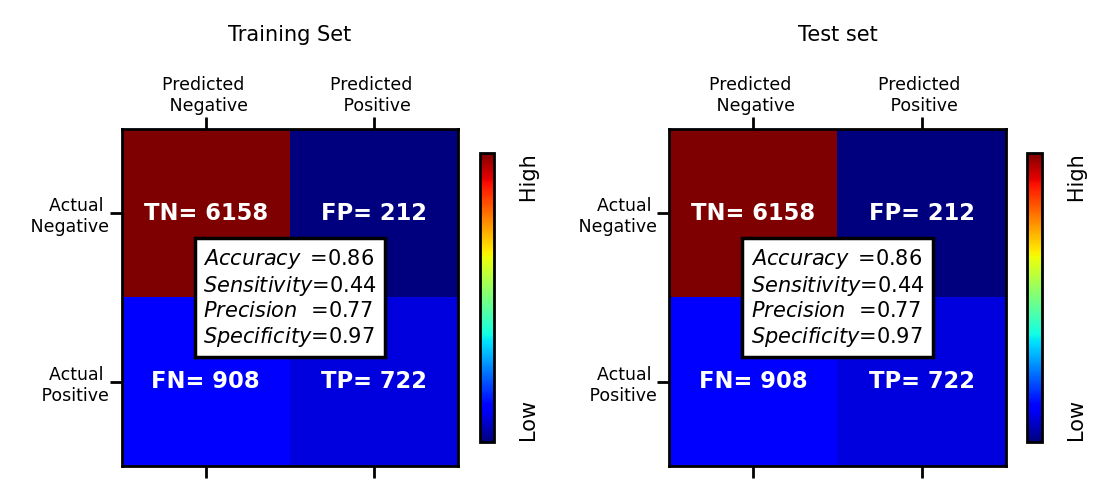

In [9]:
font = {'size'   : 6}
plt.rc('font', **font)
fig = plt.subplots(figsize=(5, 5), dpi= 250, facecolor='w', edgecolor='k')  
ax1=plt.subplot(1,2,1)
_,_,_,_=prfrmnce_plot.Conf_Matrix(y_train,y_train_pred.reshape(-1,1),axt=ax1,
                            t_fontsize=6,x_fontsize=5,y_fontsize=5,title='Training Set')

ax1=plt.subplot(1,2,2)
_,_,_,_=prfrmnce_plot.Conf_Matrix(y_train,y_train_pred.reshape(-1,1),axt=ax1,
                            t_fontsize=6,x_fontsize=5,y_fontsize=5,title='Test set')
plt.subplots_adjust(wspace=0.3)

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. **Hence the ROC curve plots sensitivity (recall) versus 1 – specificity.**

For more information and details about ROC, see [ROC](https://acutecaretesting.org/en/articles/roc-curves-what-are-they-and-how-are-they-used#:~:text=The%20ROC%20curve%20is%20a,TP%2F(TP%2BFN))

**Thus every point on the ROC curve represents a chosen cut-off even though you cannot see this cut-off. What you can see is the true positive fraction and the false positive fraction that you will get when you choose this cut-off.**

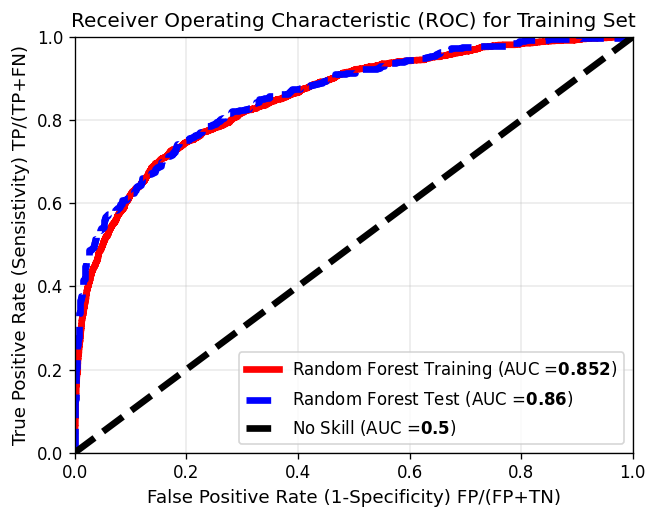

In [10]:
font = {'size' : 10}
plt.rc('font', **font)
fig = plt.subplots(figsize=(6,4.5), dpi= 120, facecolor='w', edgecolor='k')

# Random Forest for taining
y=y_train
pred=y_train_proba_rnd[:,1]
fpr, tpr, thresold = roc_curve(y, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'r', linewidth=4,label='Random Forest Training'+' (AUC =' + r"$\bf{" + str(np.round(roc_auc,3)) + "}$"+')')

# Random Forest for test set
y=y_test
pred=y_test_proba_rnd[:,1]
fpr, tpr, thresold = roc_curve(y, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b--', linewidth=4,label='Random Forest Test'+' (AUC =' + r"$\bf{" + str(np.round(roc_auc,3)) + "}$"+')')


# Random Classifier
ns_probs = [1 for _ in range(len(y))]
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
roc_auc = auc(ns_fpr, ns_tpr)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, 'k--', linewidth=4,label='No Skill'+' (AUC =' + r"$\bf{" + str(np.round(roc_auc,3)) + "}$"+')')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1-Specificity) FP/(FP+TN)',fontsize=11)
plt.ylabel('True Positive Rate (Sensistivity) TP/(TP+FN)',fontsize=11)
plt.title('Receiver Operating Characteristic (ROC) for Training Set',fontsize=12)
plt.grid(linewidth='0.25')
plt.legend(loc="lower right")

plt.show()

AUC of training set is very close to test set. So, there is no overfitting.

# Threshold from Bootstrapping

We can change the threshold to decrease precision that leads to increase sensitivity. See the Figure below for the plot of precision and sensitivity for each threshold. By decreasing the threshold from 0.5 to 0.29, sensitivity will increase.

Instead of manipulating data by oversamplaning or undersampling, we can simply tweak threshold to make reliable sensitivity or precision.

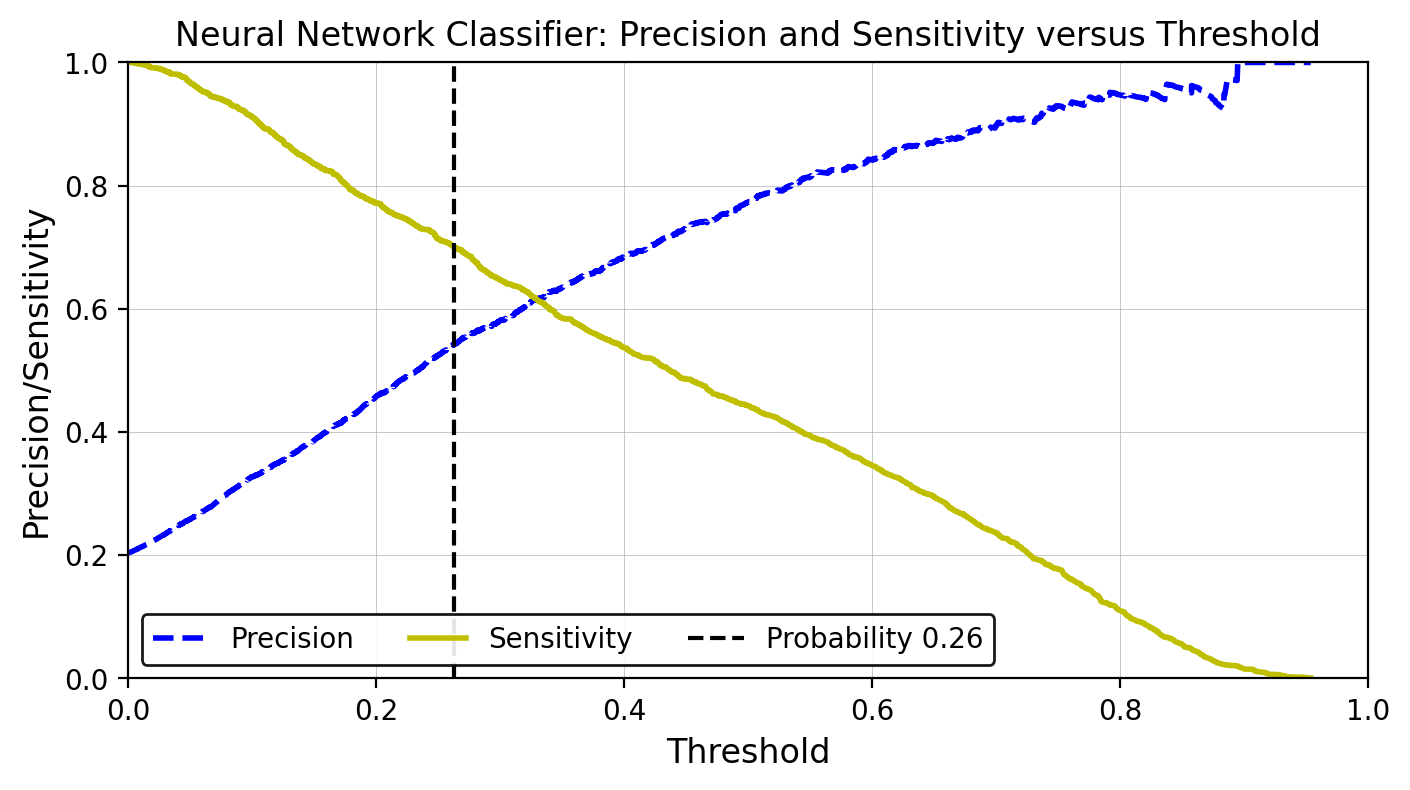

In [15]:
font = {'size' : 10}
plt.rc('font', **font)
fig = plt.subplots(figsize=(8,4), dpi= 200, facecolor='w', edgecolor='k')

pred=y_train_proba_rnd[:,1]
precisions, sensitivity, thresholds = precision_recall_curve(y_train, pred)

# Find a threshold with sensitivity higher than 0.7 and precision higher than 0.5
threshold=np.max(thresholds[np.where((sensitivity>0.7) & (precisions>0.50))])
plot_precision_recall_vs_threshold(precisions, sensitivity, thresholds,x=threshold)
plt.show()

However, the threshold is achieved based on training data. In order to get more reliable threshold, we can run a bootstrapping, dividing the data into training set and set. For each run, a model is trained with the training set and applied the trained model on test set to find a threshold that has required metrics (for example sensitivity>0.7).

In [16]:
%%time
acr_out_of_smpl = []
rec_out_of_smpl = []
threshold_=       []

# Apply 100 bootstraping sampling
n_splits=100
boot = StratifiedShuffleSplit(n_splits=n_splits,test_size=0.2, random_state=42)

num = 0
for train_idx, test_idx in boot.split(X_train_std, y_train):
    
    x_b_train = X_train_std[train_idx]
    y_b_train = y_train[train_idx]
    x_b_test  = X_train_std[test_idx]
    y_b_test  = y_train[test_idx]  
    #
    rnd.fit(x_b_train, y_b_train)
    pred = rnd.predict_proba(x_b_test)[:,1]
    
    precisions, sensitivity, thresholds = precision_recall_curve(y_b_test, pred)
    
    try:
        num+=1
        # Only find the thresholds that has sensitivity>0.75 and precisions>0.50
        threshold=np.max(thresholds[np.where((sensitivity>0.75) & (precisions>0.50))])
        pred=[1 if i >= threshold else 0 for i in pred]    
        
        acr=accuracy_score(y_b_test, pred) 
        reca=recall_score(y_b_test, pred) 
        
        acr_out_of_smpl.append(acr)
        rec_out_of_smpl.append(reca)
        threshold_.append(threshold)
        # Record this
        print('Sample #'+str(num)+', Accuracy='+str(np.round(acr,4))+
              ', Recall='+str(np.round(reca,4)), 'threshold='+str(np.round(threshold,4)))
        
    except ValueError:
        pass

Sample #3, Accuracy=0.8062, Recall=0.7515 threshold=0.2295
Sample #5, Accuracy=0.8006, Recall=0.7515 threshold=0.2407
Sample #8, Accuracy=0.81, Recall=0.7515 threshold=0.2327
Sample #9, Accuracy=0.8081, Recall=0.7515 threshold=0.2552
Sample #11, Accuracy=0.8288, Recall=0.7515 threshold=0.2556
Sample #12, Accuracy=0.81, Recall=0.7515 threshold=0.2479
Sample #13, Accuracy=0.8062, Recall=0.7515 threshold=0.2454
Sample #15, Accuracy=0.8088, Recall=0.7515 threshold=0.2385
Sample #16, Accuracy=0.7969, Recall=0.7515 threshold=0.2318
Sample #17, Accuracy=0.815, Recall=0.7515 threshold=0.2643
Sample #18, Accuracy=0.8219, Recall=0.7515 threshold=0.2438
Sample #19, Accuracy=0.8169, Recall=0.7515 threshold=0.246
Sample #24, Accuracy=0.8006, Recall=0.7515 threshold=0.2346
Sample #26, Accuracy=0.8069, Recall=0.7515 threshold=0.2258
Sample #28, Accuracy=0.8025, Recall=0.7515 threshold=0.229
Sample #31, Accuracy=0.8012, Recall=0.7515 threshold=0.2114
Sample #32, Accuracy=0.8006, Recall=0.7515 threshol

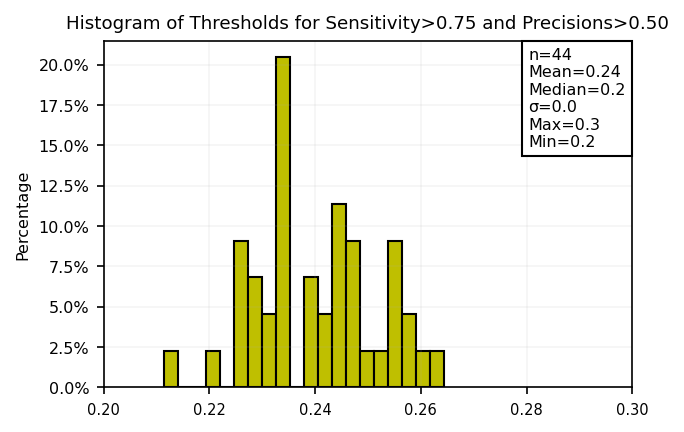

In [27]:
font = {'size'   : 7}
plt.rc('font', **font)
fig = plt.subplots(figsize=(10, 3), dpi= 150, facecolor='w', edgecolor='k')
ax1=plt.subplot(1,2,1)
bins = np.array([-0.05,0.05,0.95,1.05])
EDA_plot.histplt (np.array(threshold_),bins=20,title="Histogram of Thresholds for Sensitivity>0.75 and Precisions>0.50",
        xlabl="",xlimt=(0.2,0.3),axt=ax1, scale=1.1,loc=1,font=7,color='y',ylabl='Percentage')
plt.show()

Now calculate the metrics with the optimum threshold for test set. The optimum threshold is 0.24, the average of bootstrapping. Now we apply 0.24 threshold to test set.

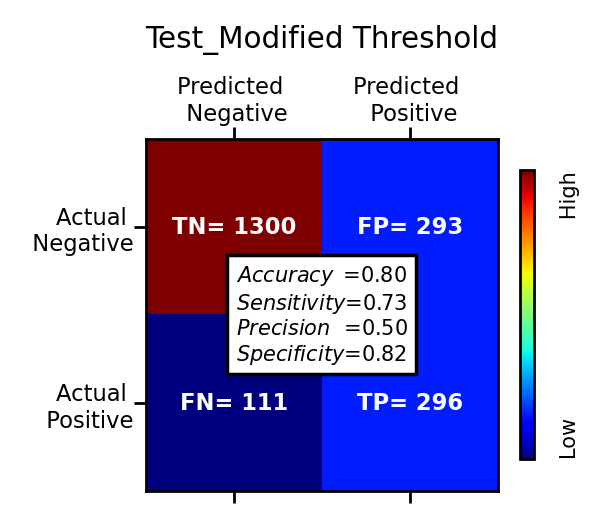

In [31]:
font = {'size'   : 6}
plt.rc('font', **font)
fig = plt.subplots(figsize=(5, 5), dpi= 250, facecolor='w', edgecolor='k')  

# Fit Random Forest classifier
rnd.fit(X_train_std,y_train)

# Random Forest for test set
y_test_pred=rnd.predict(X_test_std)
y_test_proba_rnd=rnd.predict_proba(X_test_std)[:,1]

y_p=[1 if i >= np.mean(threshold_) else 0 for i in y_test_proba_rnd]

ax1=plt.subplot(1,2,1)
Te_Accu_MT,Te_Pre_MT,Te_Rec_MT,Te_Spe_MT=prfrmnce_plot.Conf_Matrix(y_test,np.array(y_p).reshape(-1,1),
                                                                   axt=ax1,title='Test_Modified Threshold')

# Resampling

Resampling techniques are used to adjust the class distribution of training data (the ratio between the different classes) to feed more balanced data into predictive models; thereby creating a new transformed version of the training set with a different class distribution. Two main approaches for randomly resampling an imbalanced dataset are:

* **Undersampling**: This approach deletes random instances of a majority class from the training set. In the transformed version of the training set, the number of instances for the majority class are reduced. This process is repeated to achieve the desired class distribution, such as an equal number of instances for each class. This approach may be more efficient when there are a lot of instances in the majority class. A drawback of undersampling is eliminating the instances that may be important, useful, or critical for fitting a robust decision boundary (He and Ma, 2013; Brownlee, 2021). In this study, undersampling was considered for the instances with missing well properties. Although missing data are already imputed, it is better to remove random instances that have imputed values instead of non-missing instances.


* **Oversampling**: This approach adds random instances (duplicate) of the minority class to the training set. Instances from the minority class are selected and added to the training data to generate a new balanced training set. The samples are chosen from the original training set. Oversampling may be applied when there are limited instances in the minority class. A disadvantage of this technique is that it increases the likelihood of overfitting because of including the exact copies of the minority class examples (Fernández et al., 2018; Brownlee, 2021). In this study, we used LU unconditional simulation for oversampling to avoid the inclusion of exact duplicates as discussed. This approach is fast and includes associated uncertainty for resampling.

K-fold cross validation can be applied on the transformed version of the training set. However, K-fold cross validation after resampling incorrectly leads to overoptimism and overfitting since the class distribution of the original
data is different from the sampled training set (Santos et al., 2018). **The correct approach is to resample within K-fold cross validation.** The training set is divided into k stratified splits: the folds of each split have the same class distribution (percentage) of the original data. Resampling was applied on the training folds of each split. A model was trained on the resampled training folds. The test fold, which preserves the percentage of samples for each class in the original dataset, was predicted with the trained model.

In [11]:
# Features and target
x=X_train_std
y=y_train
corr=X_train.corr().to_numpy()

## Oversampling

In [16]:
%%time
rnd = RandomForestClassifier(n_estimators=50, max_depth= 25, min_samples_split= 20, bootstrap= True, random_state=42)
predictor=rnd
# Array for Oversampling ratio
Ratio=np.arange(0.35,1.65,0.1)
Train_over_Accu=len(Ratio)*[None]
Train_over_Pre =len(Ratio)*[None] 
Train_over_Rec =len(Ratio)*[None] 
Train_over_Spe =len(Ratio)*[None]
#
Train_over_during_Accu=len(Ratio)*[None]
Train_over_during_Pre =len(Ratio)*[None] 
Train_over_during_Rec =len(Ratio)*[None] 
Train_over_during_Spe =len(Ratio)*[None]

for i in range(len(Ratio)):
    ####################### Cross Validation after oversampling #######################
    over_x, over_y = x_temp,y_temp=Over_Under_Sampling(x,y,ind=0,r1=Ratio[i],r2=None,corr=corr,seed=34)
    # Fit Random Forest classifier
    rnd.fit(over_x, over_y)
    y_train_pred=cross_val_predict(rnd,over_x, over_y, cv=3)
    acr, prec, reca, spec=prfrmnce_plot.Conf_Matrix(over_y,y_train_pred.reshape(-1,1),axt=ax1,plot=False)
    Train_over_Accu[i]=acr
    Train_over_Pre [i]=prec
    Train_over_Rec [i]=reca
    Train_over_Spe [i]=spec

    ###################### Cross Validation during oversampling #######################
    y_train_pred,y_real,model__ =Ove_Und_During_Cross(x,y,predictor,ind=0,
                                                                     r1=Ratio[i],r2=None,corr=corr,seed=34,cv=5)
    acr, prec, reca, spec=prfrmnce_plot.Conf_Matrix(y_real,y_train_pred.reshape(-1,1),axt=ax1,plot=False)
    Train_over_during_Accu[i]=acr
    Train_over_during_Pre [i]=prec
    Train_over_during_Rec [i]=reca
    Train_over_during_Spe [i]=spec    

Wall time: 20min 49s


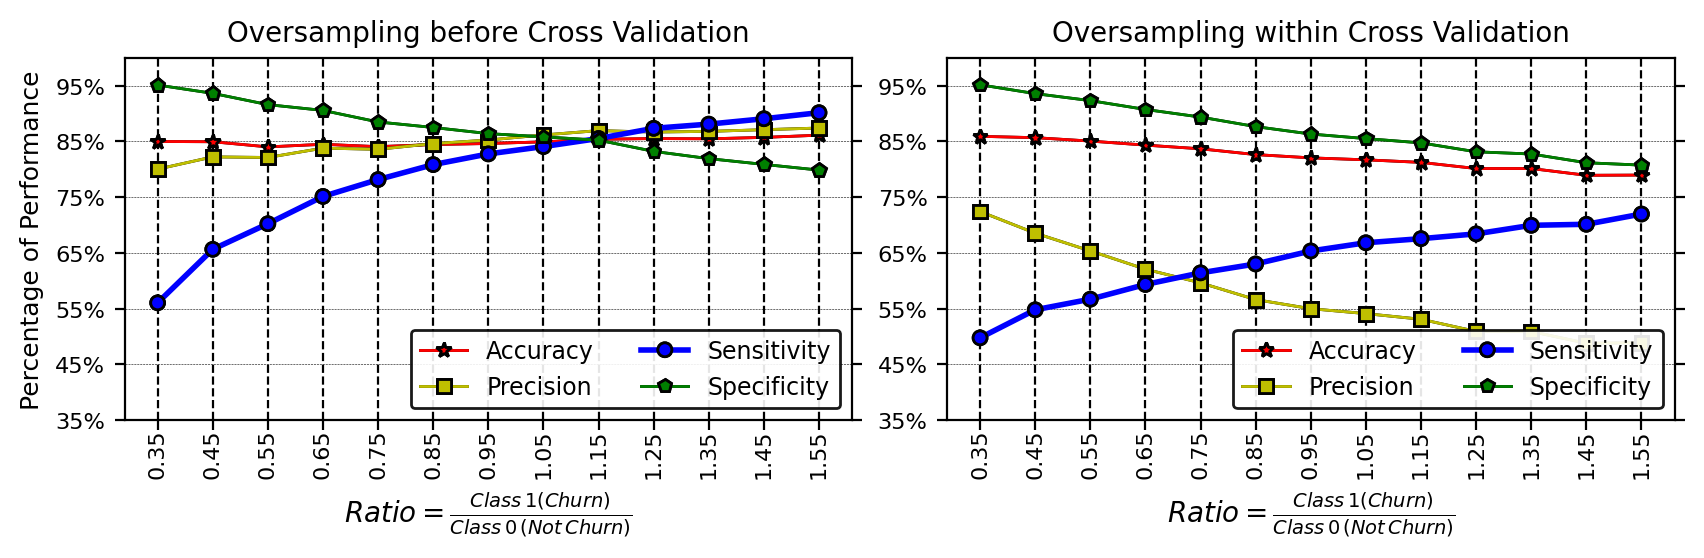

In [17]:
font = {'size'   :8.1 }
plt.rc('font', **font)
fig=plt.figure(figsize=(10, 6), dpi= 200, facecolor='w', edgecolor='k')

gs = gridspec.GridSpec(2, 4)
ax1=plt.subplot(gs[0, :2], ) 

ax1.plot(Ratio,Train_over_Accu,'r*-',linewidth=1,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                             markersize=5.5,label='Accuracy',markeredgecolor='k')
ax1.plot(Ratio,Train_over_Pre,'ys-',linewidth=1,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                             markersize=5,label='Precision',markeredgecolor='k') 
ax1.plot(Ratio,Train_over_Rec,'bo-',linewidth=2,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                             markersize=5,label='Sensitivity',markeredgecolor='k') 
ax1.plot(Ratio,Train_over_Spe,'gp-',linewidth=1,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                           markersize=5,label='Specificity',markeredgecolor='k')       
ax1.xaxis.grid(color='k', linestyle='--', linewidth=0.8) 
ax1.yaxis.grid(color='k', linestyle='--', linewidth=0.2)
plt.xlabel(r'$Ratio=\frac{Class\,1 (Churn)}{Class\,0\,(Not\,Churn)}$',fontsize=10)
plt.ylabel('Percentage of Performance',fontsize=9)
plt.title('Oversampling before Cross Validation',fontsize=10)
legend=plt.legend(ncol=2,loc=4,fontsize=8.5,framealpha =0.9) 
legend.get_frame().set_edgecolor("black")
plt.yticks(Ratio)
plt.xticks(Ratio, rotation=90, fontsize=8,y=0.03)
ax1.yaxis.set_ticks_position('both')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylim((0.35,1.00))


ax1=plt.subplot(gs[0, 2:]) 

ax1.plot(Ratio,Train_over_during_Accu,'r*-',linewidth=1,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                             markersize=5.5,label='Accuracy',markeredgecolor='k')
ax1.plot(Ratio,Train_over_during_Pre,'ys-',linewidth=1,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                             markersize=5,label='Precision',markeredgecolor='k') 
ax1.plot(Ratio,Train_over_during_Rec,'bo-',linewidth=2,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                             markersize=5,label='Sensitivity',markeredgecolor='k') 
ax1.plot(Ratio,Train_over_during_Spe,'gp-',linewidth=1,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                           markersize=5,label='Specificity',markeredgecolor='k')       
ax1.xaxis.grid(color='k', linestyle='--', linewidth=0.8) 
ax1.yaxis.grid(color='k', linestyle='--', linewidth=0.2)
plt.xlabel(r'$Ratio=\frac{Class\,1 (Churn)}{Class\,0\,(Not\,Churn)}$',fontsize=10)
plt.title('Oversampling within Cross Validation',fontsize=10)
legend=plt.legend(ncol=2,loc=4,fontsize=8.5,framealpha =0.9) 
legend.get_frame().set_edgecolor("black")
plt.yticks(Ratio)
plt.xticks(Ratio, rotation=90, fontsize=8,y=0.03)
ax1.yaxis.set_ticks_position('both')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylim((0.35,1.00))

plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.55)
#plt.ylim(0.55,0.75)
plt.show()

As it is expected, oversampling before cross validation (left Figure) leads to overfitting. Right Figure is more relibale which is oversampling within cross validation as it was explained before. The sensitivity increases by increasing the $Ratio=\frac{Class\,1 (Churn)}{Class\,0\,(Not\,Churn)}$ but precision drops rapidly. 

## Undersampling

Figures below show results of undersampling.

Undersampling may be more reliable for those datasets where we have enough data. **A limitation of undersampling is deleting useful, important, or critical data. Since the examples are deleted randomly, there is no way to detect or retrieve “good” or more information-rich examples from the majority class.**

In [18]:
%%time
rnd = RandomForestClassifier(n_estimators=50, max_depth= 25, min_samples_split= 20, bootstrap= True, random_state=42)
predictor=rnd
# Oversampling
Ratio=np.arange(0.35,1.65,0.1)
#Ratio=np.arange(0.85,1.25,0.1)
Train_over_under_Accu=len(Ratio)*[None]
Train_over_under_Pre =len(Ratio)*[None] 
Train_over_under_Rec =len(Ratio)*[None] 
Train_over_under_Spe =len(Ratio)*[None]
#
Train_under_during_Accu=len(Ratio)*[None]
Train_under_during_Pre =len(Ratio)*[None] 
Train_under_during_Rec =len(Ratio)*[None] 
Train_under_during_Spe =len(Ratio)*[None]

for i in range(len(Ratio)):
    ####################### Cross Validation after undersampling #######################
    over_x, over_y = x_temp,y_temp=Over_Under_Sampling(x,y,ind=1,r1=None,r2=Ratio[i],corr=corr,seed=34)
    # Fit Random Forest classifier
    rnd.fit(over_x, over_y)
    y_train_pred=cross_val_predict(rnd,over_x, over_y, cv=3)
    acr, prec, reca, spec=prfrmnce_plot.Conf_Matrix(over_y,y_train_pred.reshape(-1,1),axt=ax1,plot=False)
    Train_over_under_Accu[i]=acr
    Train_over_under_Pre [i]=prec
    Train_over_under_Rec [i]=reca
    Train_over_under_Spe [i]=spec
    

    ###################### Cross Validation during undersampling #######################
    y_train_pred,y_real,model__ =Ove_Und_During_Cross(x,y,predictor,ind=1,
                                                                     r1=None,r2=Ratio[i],corr=corr,seed=34,cv=5)
    acr, prec, reca, spec=prfrmnce_plot.Conf_Matrix(y_real,y_train_pred.reshape(-1,1),axt=ax1,plot=False)
    Train_over_under_during_Accu[i]=acr
    Train_over_under_during_Pre [i]=prec
    Train_over_under_during_Rec [i]=reca
    Train_over_under_during_Spe [i]=spec    

Wall time: 17.2 s


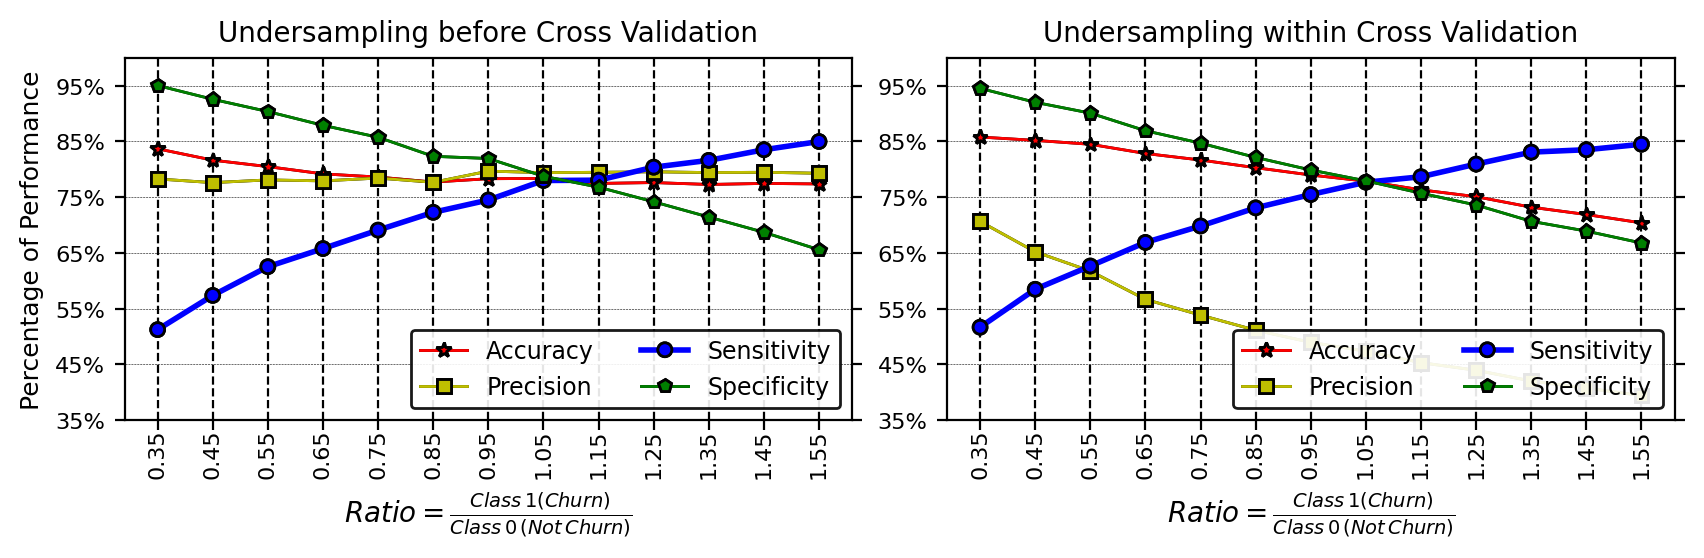

In [23]:
font = {'size'   :8.1 }
plt.rc('font', **font)
fig=plt.figure(figsize=(10, 6), dpi= 200, facecolor='w', edgecolor='k')

gs = gridspec.GridSpec(2, 4)
ax1=plt.subplot(gs[0, :2], ) 

ax1.plot(Ratio,Train_under_Accu,'r*-',linewidth=1,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                             markersize=5.5,label='Accuracy',markeredgecolor='k')
ax1.plot(Ratio,Train_under_Pre,'ys-',linewidth=1,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                             markersize=5,label='Precision',markeredgecolor='k') 
ax1.plot(Ratio,Train_under_Rec,'bo-',linewidth=2,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                             markersize=5,label='Sensitivity',markeredgecolor='k') 
ax1.plot(Ratio,Train_under_Spe,'gp-',linewidth=1,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                           markersize=5,label='Specificity',markeredgecolor='k')       
ax1.xaxis.grid(color='k', linestyle='--', linewidth=0.8) 
ax1.yaxis.grid(color='k', linestyle='--', linewidth=0.2)
plt.xlabel(r'$Ratio=\frac{Class\,1 (Churn)}{Class\,0\,(Not\,Churn)}$',fontsize=10)
plt.ylabel('Percentage of Performance',fontsize=9)
plt.title('Undersampling before Cross Validation',fontsize=10)
legend=plt.legend(ncol=2,loc=4,fontsize=8.5,framealpha =0.9) 
legend.get_frame().set_edgecolor("black")
plt.yticks(Ratio)
plt.xticks(Ratio, rotation=90, fontsize=8,y=0.03)
ax1.yaxis.set_ticks_position('both')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylim((0.35,1.00))


ax1=plt.subplot(gs[0, 2:]) 

ax1.plot(Ratio,Train_under_during_Accu,'r*-',linewidth=1,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                             markersize=5.5,label='Accuracy',markeredgecolor='k')
ax1.plot(Ratio,Train_under_during_Pre,'ys-',linewidth=1,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                             markersize=5,label='Precision',markeredgecolor='k') 
ax1.plot(Ratio,Train_under_during_Rec,'bo-',linewidth=2,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                             markersize=5,label='Sensitivity',markeredgecolor='k') 
ax1.plot(Ratio,Train_under_during_Spe,'gp-',linewidth=1,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                           markersize=5,label='Specificity',markeredgecolor='k')       
ax1.xaxis.grid(color='k', linestyle='--', linewidth=0.8) 
ax1.yaxis.grid(color='k', linestyle='--', linewidth=0.2)
plt.xlabel(r'$Ratio=\frac{Class\,1 (Churn)}{Class\,0\,(Not\,Churn)}$',fontsize=10)
plt.title('Undersampling within Cross Validation',fontsize=10)
legend=plt.legend(ncol=2,loc=4,fontsize=8.5,framealpha =0.9) 
legend.get_frame().set_edgecolor("black")
plt.yticks(Ratio)
plt.xticks(Ratio, rotation=90, fontsize=8,y=0.03)
ax1.yaxis.set_ticks_position('both')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylim((0.35,1.00))

plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.55)
#plt.ylim(0.55,0.75)
plt.show()

The sensitivity increases by increasing the ratio $\frac{Class\,1 (Churn)}{Class\,0\,(Not\,Churn)}$.

## Combination of Oversampling and Undersampling

Combining of both oversampling and undersampling can lead to improved overall performance in comparison with performing one approach in isolation (Brownlee, 2021). We combined both techniques with equal percentage: undersampling with a selected percentage is applied to the majority class to reduce the bias on that class, while also applying the same percentage for oversampling of the minority class to improve the bias towards these instances. Resampling was applied for different ratios of 𝐶𝑙𝑎𝑠𝑠 0 and 𝐶𝑙𝑎𝑠𝑠 1. For each ratio, the metrics accuracy, specificity, sensitivity, and AUC (area under the curve) were calculated. The ratio that has similar performance for all the metrics is the most reliable ratio.

In [20]:
%%time
rnd = RandomForestClassifier(n_estimators=50, max_depth= 25, min_samples_split= 20, bootstrap= True, random_state=42)
predictor=rnd
# Combination of oversampling and undersampling
Ratio=np.arange(0.05,1.65,0.1)
Train_over_under_Accu=len(Ratio)*[None]
Train_over_under_Pre =len(Ratio)*[None] 
Train_over_under_Rec =len(Ratio)*[None] 
Train_over_under_Spe =len(Ratio)*[None]
#
Train_over_under_during_Accu=len(Ratio)*[None]
Train_over_under_during_Pre =len(Ratio)*[None] 
Train_over_under_during_Rec =len(Ratio)*[None] 
Train_over_under_during_Spe =len(Ratio)*[None]

for i in range(len(Ratio)):
    ####################### Cross Validation after over and undersampling #######################
    over_under_x, over_under_y = x_temp,y_temp=Over_Under_Sampling(x,y,ind=2,r1=Ratio[i],r2=Ratio[i],corr=corr,seed=34)
    # Fit Random Forest classifier
    rnd.fit(over_under_x, over_under_y)
    y_train_pred=cross_val_predict(rnd,over_under_x, over_under_y, cv=3)
    acr, prec, reca, spec=prfrmnce_plot.Conf_Matrix(over_under_y,y_train_pred.reshape(-1,1),axt=ax1,plot=False)
    Train_over_under_Accu[i]=acr
    Train_over_under_Pre [i]=prec
    Train_over_under_Rec [i]=reca
    Train_over_under_Spe [i]=spec
    

    ###################### Cross Validation during over and undersampling #######################
    y_train_pred,y_real,model__ =Ove_Und_During_Cross(x,y,predictor,ind=2,
                                                                     r1=Ratio[i],r2=Ratio[i],corr=corr,seed=34,cv=5)
    acr, prec, reca, spec=prfrmnce_plot.Conf_Matrix(y_real,y_train_pred.reshape(-1,1),axt=ax1,plot=False)
    Train_over_under_during_Accu[i]=acr
    Train_over_under_during_Pre [i]=prec
    Train_over_under_during_Rec [i]=reca
    Train_over_under_during_Spe [i]=spec    

Wall time: 20min 26s


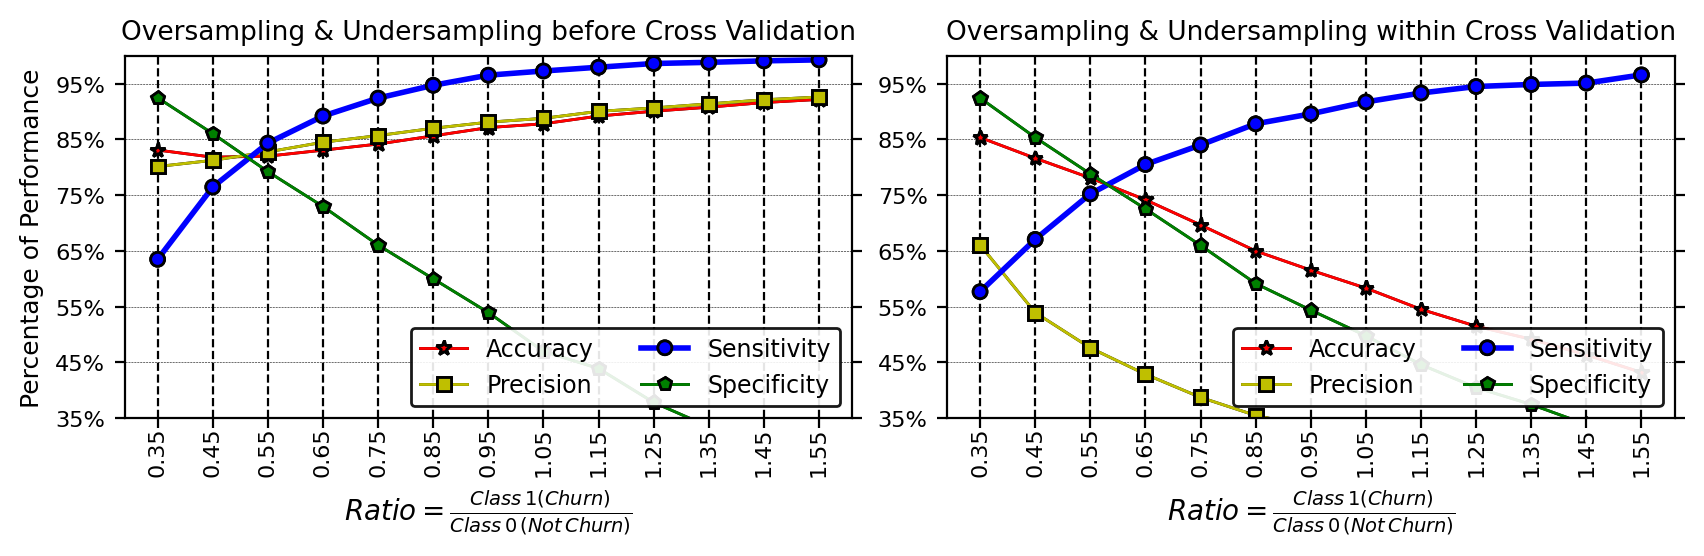

In [24]:
font = {'size'   :8.1 }
plt.rc('font', **font)
fig=plt.figure(figsize=(10, 6), dpi= 200, facecolor='w', edgecolor='k')

gs = gridspec.GridSpec(2, 4)
ax1=plt.subplot(gs[0, :2], ) 

ax1.plot(Ratio,Train_over_under_Accu,'r*-',linewidth=1,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                             markersize=5.5,label='Accuracy',markeredgecolor='k')
ax1.plot(Ratio,Train_over_under_Pre,'ys-',linewidth=1,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                             markersize=5,label='Precision',markeredgecolor='k') 
ax1.plot(Ratio,Train_over_under_Rec,'bo-',linewidth=2,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                             markersize=5,label='Sensitivity',markeredgecolor='k') 
ax1.plot(Ratio,Train_over_under_Spe,'gp-',linewidth=1,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                           markersize=5,label='Specificity',markeredgecolor='k')       
ax1.xaxis.grid(color='k', linestyle='--', linewidth=0.8) 
ax1.yaxis.grid(color='k', linestyle='--', linewidth=0.2)
plt.xlabel(r'$Ratio=\frac{Class\,1 (Churn)}{Class\,0\,(Not\,Churn)}$',fontsize=10)
plt.ylabel('Percentage of Performance',fontsize=9)
plt.title('Oversampling & Undersampling before Cross Validation',fontsize=9.5)
legend=plt.legend(ncol=2,loc=4,fontsize=8.5,framealpha =0.9) 
legend.get_frame().set_edgecolor("black")
plt.yticks(Ratio)
plt.xticks(Ratio, rotation=90, fontsize=8,y=0.03)
ax1.yaxis.set_ticks_position('both')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylim((0.35,1.00))


ax1=plt.subplot(gs[0, 2:]) 

ax1.plot(Ratio,Train_over_under_during_Accu,'r*-',linewidth=1,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                             markersize=5.5,label='Accuracy',markeredgecolor='k')
ax1.plot(Ratio,Train_over_under_during_Pre,'ys-',linewidth=1,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                             markersize=5,label='Precision',markeredgecolor='k') 
ax1.plot(Ratio,Train_over_under_during_Rec,'bo-',linewidth=2,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                             markersize=5,label='Sensitivity',markeredgecolor='k') 
ax1.plot(Ratio,Train_over_under_during_Spe,'gp-',linewidth=1,path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()],
                                                           markersize=5,label='Specificity',markeredgecolor='k')       
ax1.xaxis.grid(color='k', linestyle='--', linewidth=0.8) 
ax1.yaxis.grid(color='k', linestyle='--', linewidth=0.2)
plt.xlabel(r'$Ratio=\frac{Class\,1 (Churn)}{Class\,0\,(Not\,Churn)}$',fontsize=10)
plt.title('Oversampling & Undersampling within Cross Validation',fontsize=9.5)
legend=plt.legend(ncol=2,loc=4,fontsize=8.5,framealpha =0.9) 
legend.get_frame().set_edgecolor("black")
plt.yticks(Ratio)
plt.xticks(Ratio, rotation=90, fontsize=8,y=0.03)
ax1.yaxis.set_ticks_position('both')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylim((0.35,1.00))

plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.55)
#plt.ylim(0.55,0.75)
plt.show()

It seems combination of oversampling and undersampling lead to more reliable performance. Left Figure, sampling within cross validation, leads to overfitting. In right Figure, the $Ratio=\frac{Class\,1 (Churn)}{Class\,0\,(Not\,Churn)}=0.6$ probably is the most reliable ratio because three metrics sensitivity, accuracy and specificity are approximately equal. Therefore, this ratio is applied to apply oversampling to train a model on test set. See below:

# Test Set

Combination of oversampling and undersampling with $Ratio=\frac{Class\,1 (Churn)}{Class\,0\,(Not\,Churn)}=0.6$ is applied to train model. The trained model is applied on test set. Figure below shows a schematic illustration of resampling within 5-fold cross validation. The training set is divided into 5 stratified splits: the folds of each split have the
same class distribution (percentage) of the original data. Resampling was applied on the training folds of each split. A model was trained on the resampled training folds. The test fold, which preserves the percentage of samples for each class in the original dataset, was predicted with the trained model. This process was repeated for all 5-splits that leads to 5 models.

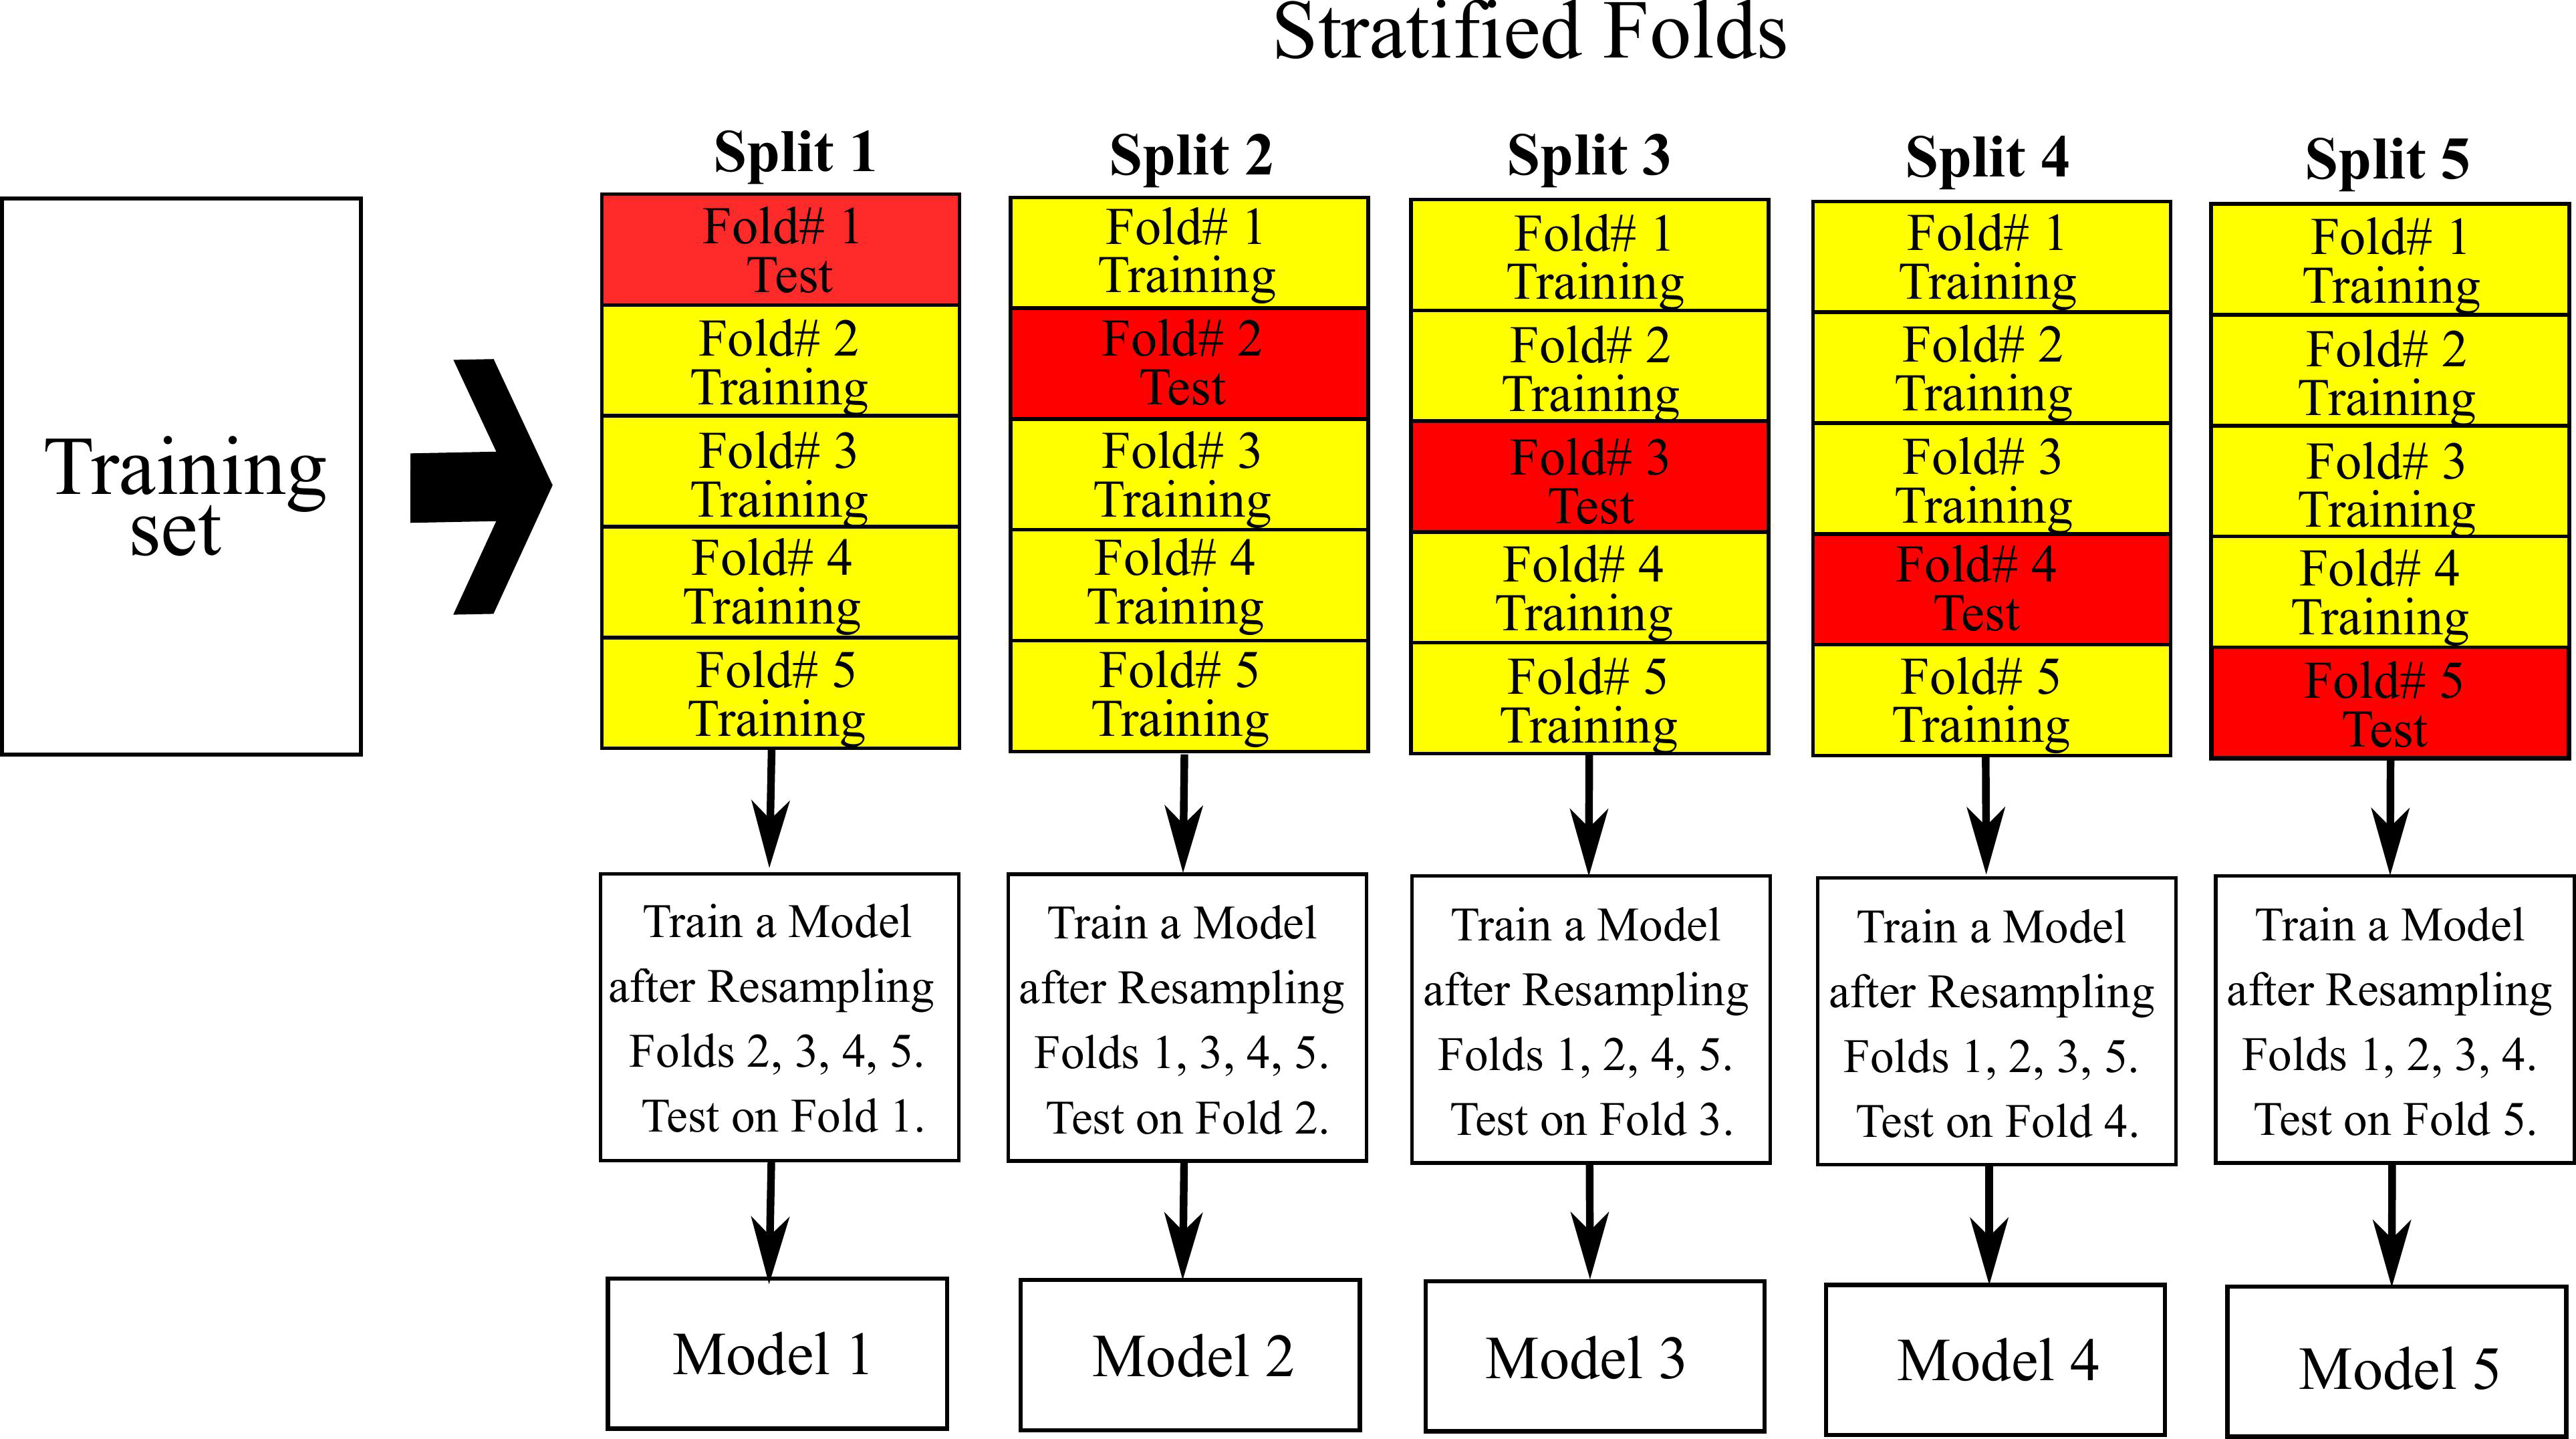

In [12]:
# Combination of oversampling and undersampling
optimum_ratio=0.6
# Random Forest
rnd = RandomForestClassifier(n_estimators=50, max_depth= 25, min_samples_split= 20, bootstrap= True, random_state=42)
predictor=rnd
y_train_pred,y_real,model__=Ove_Und_During_Cross(x,y,predictor,ind=2,r1=optimum_ratio,
                                                 r2=optimum_ratio,corr=corr,seed=34,cv=5)

The trained models 1 to 5 obtained from 5-fold cross validation (figure above) were applied separately to
predict validation using the test set. Then, the predictions from each model were aggregated and predicted
the class that gets the most votes; since each model is trained on random subsets of training sets
with random sampling, it is reasonable to aggregate the predictions. Soft voting is applied for aggregation.

In [13]:
# Soft voting   
pred=np.array([], dtype=np.int64).reshape(len(X_test_std),0)
for ii in range(len(model__)):
    tmp=model__[ii].predict_proba(X_test_std)[:,1].reshape(-1,1)
    pred=np.concatenate((tmp, pred), axis=1)
Soft_voting=[np.mean(i) for i in pred]     

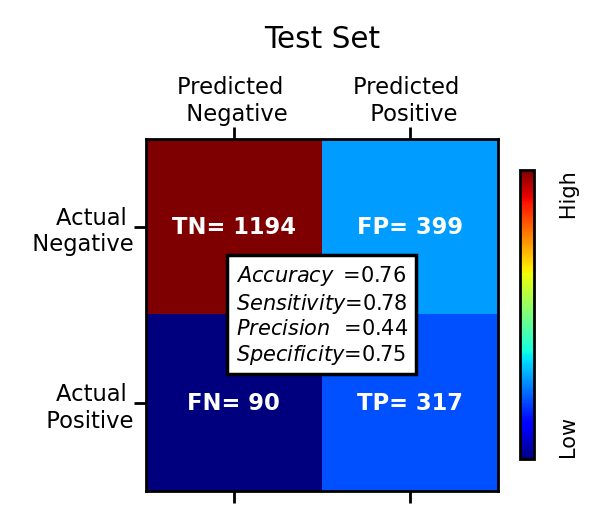

In [14]:
font = {'size'   : 6}
plt.rc('font', **font)
fig = plt.subplots(figsize=(5, 5), dpi= 250, facecolor='w', edgecolor='k')  
ax1=plt.subplot(1,2,1)

acr, prec, reca, spec=prfrmnce_plot.Conf_Matrix(y_test,np.array(Soft_voting).reshape(-1,1),axt=ax1,plot=True,title='Test Set')
test_Accu_ov_un_during_cv_rnf=acr
test_Pre_ov_un_during_cv_rnf=prec
test_Rec_ov_un_during_cv_rnf=reca
test_Spe_ov_un_during_cv_rnf=spec
fpr, tpr, thresold = roc_curve(y_test, Soft_voting)
test_AUC_ov_un_during_cv_rnf=auc(fpr, tpr)

Performance of test set indicates combining of both oversampling and undersampling lead to improved overall performance.